<img src="https://www.smartdatacollective.com/wp-content/uploads/2018/11/Machine-learning-1024x682.jpg"/>

tudor.lapusan@gmail.com

# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn import tree


import graphviz
from graphviz import Source

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

# Util functions

In [4]:
def print_score(model, train, validation):
    print(f"train accuracy {accuracy_score(train[target], model.predict(train[features_v3]))}")
    print(f"validation accuracy {accuracy_score(validation[target], model.predict(validation[features_v3]))}")
    
def print_score_reg(_model, _train, _validation):
    print(f"train MAE {mean_absolute_error(_train[target_reg], _model.predict(_train[features_reg]))}")
    print(f"validation MAE {mean_absolute_error(_validation[target_reg], _model.predict(_validation[features_reg]))}")

def save_decision_tree_structure(_decision_tree, _filename, _features):
    graph = Source(tree.export_graphviz(_decision_tree, feature_names=_features, class_names=["0", "1"],
                                                filled=True, node_ids=True))
    graph.format = 'png'
    graph.render(filename=_filename,view=True)

# Load dataset

What are we trying to solve ?

The dataset is related to the sinking of the Titanic ship. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships. <br>
If you are new to a domain, in this case ship disaster, machine learning should help us to understand also the dataset, to get domain knowledge, not only to make predictions !

[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) <br>

Before start to work on a ML project, it's important to understand what we want to achive. <br>
<b>Our goal is to predict which passengers survived the tragedy ! </b> <br> <br>




Depending of what we need to predict, the ML algorithms are devided in two main subclasses : <br>
<b>Classification </b>
- we need to predict a class/label (a limited set of values), ex. email is span or not spam, healty or not healty
- the most common is the binary classification, where we need to predict between two classes
- when we need to predict multiple classes, the problem is known as multi-class classification

<b>Regression </b>
- we need to predict a real-value, such as an integer or floating point value, ex price, age, distance 

[Differences between Classification and Regression](https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/)

In [6]:
dataset = pd.read_csv("../dataset/titanic/titanic.csv")

In [7]:
dataset.head(10)

,pclass,survived,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,False,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S
5,1,True,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S
6,1,True,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S
7,1,False,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S
8,1,True,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S
9,1,False,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C


# IDA (Initial Data Analysis)

When working on a ML project we can start with at least two approaches : <br><br>
<b>Data driven approach</b><br>
It assume to start looking at the data, to make a lot of visualisations, discover patterns. By doing this we are making a lot of assumptions about the data and what kind of information we should put in our ML model. <br>
In this way, the model could learn from our assumptions, which in some cases can be limited or incorect.


<b>ML drive approach </b><br>
This approach assume to look at the data just enough to make it ready for training a ML model (handle missing values, categorical features, etc). After we have a model trained on this data, we interprete its result, structure, behavior and based on these investigations we make assumptions about the data.

<br>
Question : which one do you practice/prefer ?

In [390]:
dataset.head(5)

,pclass,survived,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,False,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S


### Columns description
<b>pclass </b>: A proxy for socio-economic status (SES). 1st = Upper, 2nd = Middle, 3rd = Lower <br>
<b>survived</b> : True = survived, False = didn't survive <br>
<b>name</b> : passanger name <br>
<b>gender</b> : passanger gender, male or female <br>
<b>age</b> : passanger age <br>
<b>sibsp</b> : # of siblings / spouses aboard the Titanic <br>
<b>parch</b> : # of parents / children aboard the Titanic <br>
<b>ticket</b> : passanger ticket number <br>
<b>fare</b> : passenger fare <br>
<b>embarked</b> : Port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton <br>

### Check dataset size
Original titanic dataset size

In [8]:
dataset.shape

(1309, 11)

### Check column types

In [9]:
dataset.dtypes

pclass        int64
survived       bool
name         object
gender       object
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
cabin        object
embarked     object
dtype: object

### Check for missing data

In [11]:
dataset.isna().any()

pclass      False
survived    False
name        False
gender      False
age          True
sibsp       False
parch       False
ticket      False
fare         True
cabin        True
embarked     True
dtype: bool

In [12]:
dataset.isna().sum()

pclass         0
survived       0
name           0
gender         0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
dtype: int64

### Few visualisations
We understand better and faster if we look visually at the data. <br>
Python community developed a lot of useful libraries for visualistions, but the most used one is [matplotlib](https://matplotlib.org/). Check [here](https://mode.com/blog/python-data-visualization-libraries) for other popular libraries. <br> 


The most common types of visualisations are histograms, line plots and scatter plots.

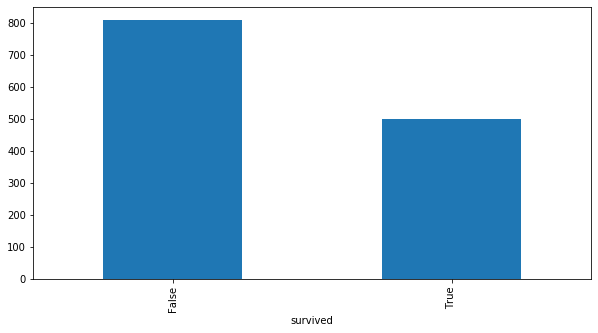

In [13]:
plt.figure(figsize=(10,5))
dataset.groupby(["survived"]).size().plot.bar()

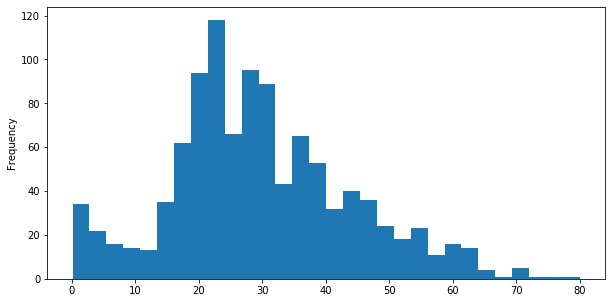

In [14]:
plt.figure(figsize=(10,5))
dataset.age.plot.hist(bins=30)

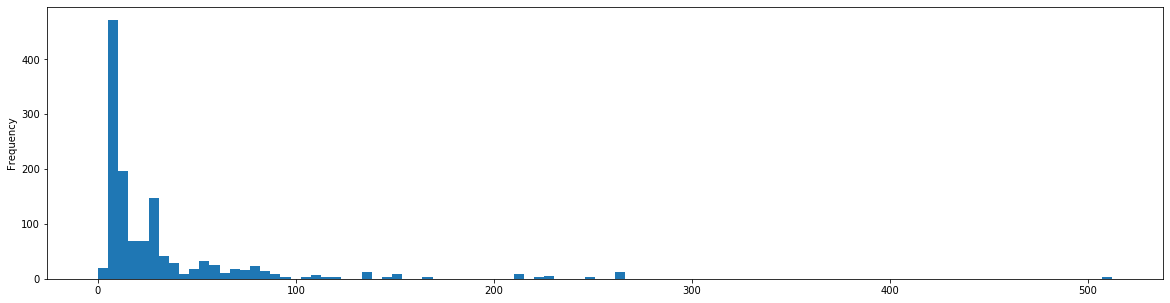

In [16]:
plt.figure(figsize=(20,5))
dataset.fare.plot.hist(bins=100)

In [21]:
print(f"fare mean {dataset.fare.mean()}, fare median {dataset.fare.median()}")

fare mean 33.29547928134557, fare median 14.4542


# Select feature set

In [25]:
dataset.head(3)

,pclass,survived,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,False,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S


In [26]:
features = ["pclass", "gender", "age", "sibsp", "parch", "ticket", "fare", "cabin", "embarked"]
target = "survived"

# Initialize and fit a Decision Tree model

A Decision Tree is simple a tree of decisions ! <br>
The tree is build based on the data and an algorithm([ID3, C4.5, CART](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart)) <br>

Most of ML libraries implement Decision Trees. Take a look at sklearn implementations for [classification](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) and for [regression](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)


<img src='https://raw.githubusercontent.com/tlapusan/tree_based_models_workshop/master/resources/images/decision_tree_sample_2.png' />



Main advantages of DecisionTree :
- can be used for both classification and regression
- don't require too much feature enginner
- they are interpretable
- they have pretty good results
- easy to learn and understand
- they are the base for other performant models, like RandomForest, XGBoost.


In [27]:
dt = DecisionTreeClassifier(max_depth=10)

In [28]:
dt.fit(dataset[features], dataset[target])

ValueError: could not convert string to float: 'female'

In [29]:
dataset.head(5)

,pclass,survived,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,False,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S


### Feature encoding
In Machine Learning we have two main types of features : <br>
- <b>Numerical features </b> <br>
    Like age, price, duration
- <b>Categorical features</b>
    - nominal features <br>
    We don't have any logical order for feature values. ex. color, job, weather conditions, 
    - ordinal features <br>
    We have a logical order. ex. education, month, t-shirt size

There are many ways to convert a categorical feature into a numerical one, almost each ML related library contains one. <br>

One of the most populars are : <br>
sklearn : [LabelEncoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) <br>
pandas : [Categorical data](http://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html)

<br>
<b>Pandas categorical data types </b><br>
Categorical data types are using integer values  to represent the raw values from a column. <br>
Behind, pandas is using a dictionary to keep all the mappings between integer values and raw values. Beside encoding functionality, categorical values can be used for memory saving.
 


In [30]:
dataset.dtypes

pclass        int64
survived       bool
name         object
gender       object
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
cabin        object
embarked     object
dtype: object

In [404]:
dataset.gender.astype("category")

0       female
1         male
2       female
3         male
4       female
5         male
6       female
7         male
8       female
9         male
10        male
11      female
12      female
13      female
14        male
15        male
16        male
17      female
18      female
19        male
20        male
21      female
22        male
23      female
24      female
25        male
26        male
27      female
28      female
29        male
         ...  
1279    female
1280      male
1281      male
1282      male
1283      male
1284      male
1285      male
1286    female
1287      male
1288      male
1289      male
1290    female
1291      male
1292      male
1293      male
1294      male
1295      male
1296      male
1297      male
1298      male
1299      male
1300    female
1301      male
1302      male
1303      male
1304    female
1305    female
1306      male
1307      male
1308      male
Name: gender, Length: 1309, dtype: category
Categories (2, object): [female, male]

In [31]:
dataset.gender.astype("category").cat.categories

Index(['female', 'male'], dtype='object')

In [32]:
dataset.gender.astype("category").cat.codes

0       0
1       1
2       0
3       1
4       0
5       1
6       0
7       1
8       0
9       1
10      1
11      0
12      0
13      0
14      1
15      1
16      1
17      0
18      0
19      1
20      1
21      0
22      1
23      0
24      0
25      1
26      1
27      0
28      0
29      1
       ..
1279    0
1280    1
1281    1
1282    1
1283    1
1284    1
1285    1
1286    0
1287    1
1288    1
1289    1
1290    0
1291    1
1292    1
1293    1
1294    1
1295    1
1296    1
1297    1
1298    1
1299    1
1300    0
1301    1
1302    1
1303    1
1304    0
1305    0
1306    1
1307    1
1308    1
Length: 1309, dtype: int8

In [407]:
dataset.isna().any()

pclass      False
survived    False
name        False
gender      False
age          True
sibsp       False
parch       False
ticket      False
fare         True
cabin        True
embarked     True
dtype: bool

In [34]:
def encode_columns_as_categories(_dataset, _column_set):
    for column in _column_set:
        if dataset[column].isna().any():
            dataset[f"{column}_missing"] = dataset[column].isna()
            
        _dataset[f"{column}_cat"] = _dataset[column].astype("category").cat.codes

In [35]:
encode_columns_as_categories(dataset, ["gender", "ticket", "cabin", "embarked"])

In [36]:
dataset.isna().any()

pclass              False
survived            False
name                False
gender              False
age                  True
sibsp               False
parch               False
ticket              False
fare                 True
cabin                True
embarked             True
gender_cat          False
ticket_cat          False
cabin_missing       False
cabin_cat           False
embarked_missing    False
embarked_cat        False
dtype: bool

In [37]:
dataset

,pclass,survived,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,gender_cat,ticket_cat,cabin_missing,cabin_cat,embarked_missing,embarked_cat
0,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,0,187,False,43,False,2
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,1,49,False,79,False,2
2,1,False,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,0,49,False,79,False,2
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,1,49,False,79,False,2
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,0,49,False,79,False,2
5,1,True,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,1,124,False,149,False,2
6,1,True,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,0,92,False,145,False,2
7,1,False,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,1,15,False,15,False,2
8,1,True,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,0,76,False,61,False,2
9,1,False,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,1,825,True,-1,False,0


Question : another advantage for using categorical data instead of raw values ?

In [39]:
features_v2 = ["pclass", "gender_cat", "age", "sibsp", "parch", "ticket_cat", "fare", "cabin_cat", "cabin_missing", "embarked_cat", "embarked_missing"]


In [40]:
dt.fit(dataset[features_v2], dataset[target])

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### Handle missing values
Having missing data in our datasets is pretty common. It can be caused by human error, software bug or simple the value isn't known. <br> 
Possible values for missing values are :  ‘NaN’, ‘NA’, ‘None’, ‘ ’, ‘?’, etc

The simplest solution is to remove the rows with missing values. The main disadvantage of this method is that we remove information from our dataset.

Another solution is to fill the missing data with some values. For numerical features, the most common method is to replace by mean or median (if there are ourliers).



In [41]:
dataset[features_v2].isna().any()

pclass              False
gender_cat          False
age                  True
sibsp               False
parch               False
ticket_cat          False
fare                 True
cabin_cat           False
cabin_missing       False
embarked_cat        False
embarked_missing    False
dtype: bool

In [42]:
dataset.age.mean()

29.8811345124283

In [43]:
dataset["age_missing"] = dataset.age.isna()
dataset["fare_missing"] = dataset.fare.isna()

In [44]:
dataset.fillna({"age":dataset.age.mean(), "fare":dataset.fare.median()}, inplace=True)

In [45]:
features_v3 = ["pclass", "gender_cat", "age", "age_missing", "sibsp", "parch", "ticket_cat", "fare", "fare_missing", "cabin_cat", "cabin_missing", "embarked_cat", "embarked_missing"]



In [46]:
dataset[features_v3].isna().any()

pclass              False
gender_cat          False
age                 False
age_missing         False
sibsp               False
parch               False
ticket_cat          False
fare                False
fare_missing        False
cabin_cat           False
cabin_missing       False
embarked_cat        False
embarked_missing    False
dtype: bool

In [47]:
dt.fit(dataset[features_v3], dataset[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Make predictions

In [49]:
dataset_predictions = dataset.sample(frac=1).head(10)

In [50]:
dataset_predictions[features_v3 + [target]]

,pclass,gender_cat,age,age_missing,sibsp,parch,ticket_cat,fare,fare_missing,cabin_cat,cabin_missing,embarked_cat,embarked_missing,survived
433,2,1,30.000000,False,0,0,927,10.5000,False,-1,True,2,False,False
331,2,1,18.000000,False,0,0,323,11.5000,False,-1,True,2,False,False
1299,3,1,27.000000,False,1,0,253,14.4542,False,-1,True,0,False,False
56,1,1,36.000000,False,1,2,43,120.0000,False,60,False,2,False,True
535,2,1,43.000000,False,0,1,842,21.0000,False,-1,True,2,False,False
998,3,1,29.881135,True,0,0,538,7.8958,False,-1,True,0,False,False
955,3,0,29.881135,True,3,1,671,25.4667,False,-1,True,2,False,False
126,1,1,37.000000,False,1,0,65,53.1000,False,70,False,2,False,False
292,1,1,48.000000,False,1,0,127,52.0000,False,73,False,2,False,True
1290,3,0,47.000000,False,1,0,582,7.0000,False,-1,True,2,False,True


DecisionTreeClassifier contains predict and predict_proba methods for making predictions : <br>
- predict method returns the predicted class 
- predict_proba returns the class probabilities 

In [51]:
dt.predict(dataset_predictions[features_v3])

array([False, False, False,  True, False, False, False,  True,  True,
        True])

In [52]:
dt.predict_proba(dataset_predictions[features_v3])

array([[1.        , 0.        ],
       [0.93172691, 0.06827309],
       [0.86153846, 0.13846154],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.86153846, 0.13846154],
       [1.        , 0.        ],
       [0.4375    , 0.5625    ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

Question: How is decided the predicted class ?


### Model validation

The role of model validation is to check the model performance ! <br>

In our case, we need to correctly classify if a person survived or didn't survived. So, our model should predict as many as possible, the correct answers.

The metric we should use is the accuracy metric. It tells us the percentage of correct predictions made by our model, in others words : accuracy = (number of corrent predictions / total number of predictions). <br>
[Check for others validation metrics for classification](https://scikit-learn.org/stable/modules/classes.html#classification-metrics)



In [53]:
accuracy_score(dataset[target], dt.predict(dataset[features_v3]))

0.9167303284950343

### Validation strategies  

The rule number one : validation strategy should reflect as much as possible how the model will behave in production. <br>

The most common validation strategy is holdout method, where we split our dataset in two parts, training and validation datasets. <br>
One splitting method would be to shuffle the data and choose 70% of them in training and 30% into validation. 

In [61]:
random_state = 1234
train, validation = train_test_split(dataset, train_size=0.7, random_state=random_state, stratify = dataset.survived)



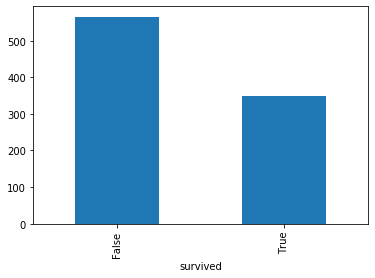

In [62]:
train.groupby([target]).size().plot.bar()

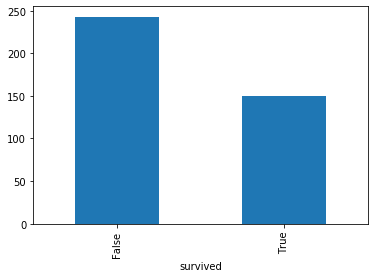

In [63]:
validation.groupby([target]).size().plot.bar()

In [64]:
dt = DecisionTreeClassifier(max_depth=10, random_state=random_state)
dt.fit(train[features_v3], train[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [65]:
print_score(dt, train, validation)

train accuracy 0.9115720524017468
validation accuracy 0.8015267175572519


### Model interpretation
A ML project can have two main purposes : <br> 
 - to make predictions and to use them in production
 - to understand your data and to get domain knowledge
 
Question : on what type of ML project did you work until now ?

In [83]:
save_decision_tree_structure(dt, "dt_sample", features_v3)

Most of the time, to build a performant Decision Tree, we need to build a complex tree, with many levels and a lot of nodes. <br>
In this scenarios, Decision Tree is losing one of its main advantage : interpretability

This is the main reason I started to create a library from scratch, [woodpecker](https://github.com/tlapusan/woodpecker), to help me to interprete the decision tree structure, even if it's very big.


#### Woodpecker

##### Install

In [70]:
#pip install git+https://github.com/tlapusan/woodpecker.git

In [70]:
import sys
import os
# add library tree module to PYTHONPATH
sys.path.append("/Users/tudorlapusan/Documents/workspaces/ml/woodpecker")

In [71]:
from woodpecker.decision_tree_structure_classifier import DecisionTreeStructureClassifier

In [72]:
dts = DecisionTreeStructureClassifier(dt, train, features_v3, target)

##### Feature importance
Feature importance is one of the first visualisation I make for model interpretation.

Question : What we can obtain from feature importance ?
 - focus on most important dataset columns, make more visualisations with them
 - discuss with a business analyst, client and debate on them
 - discover potential data leakages
 - give you a clue if you are on the right way
 

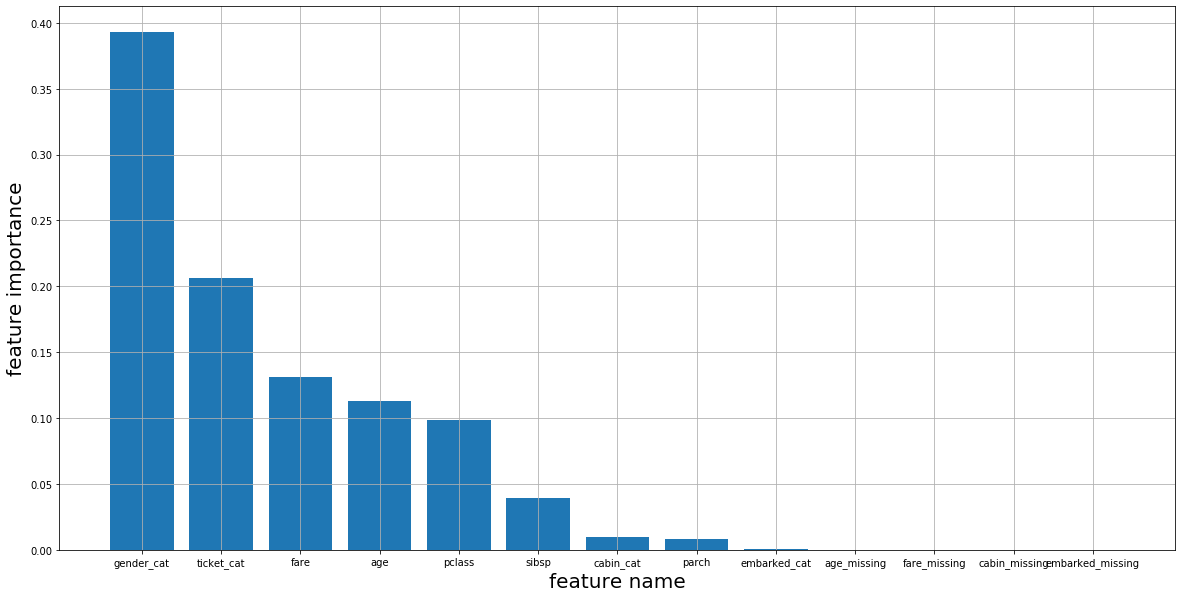

In [73]:
dts.show_features_importance()

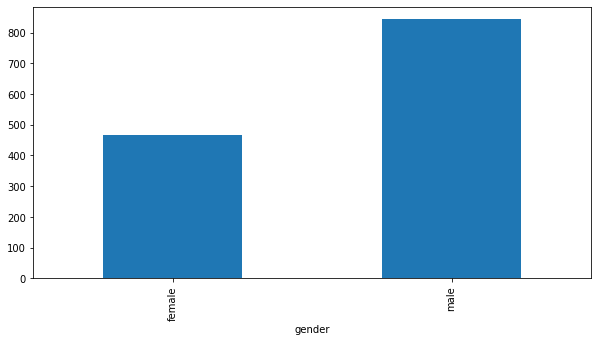

In [74]:
plt.figure(figsize=(10,5))
dataset.groupby("gender").size().plot.bar()

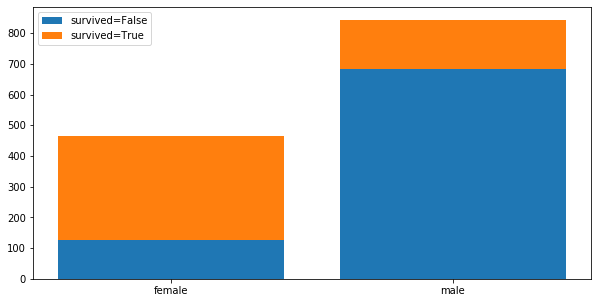

In [75]:
survive_gender_corr = dataset.groupby(["survived", "gender"]).size()
plt.figure(figsize=(10,5))
plt.bar(survive_gender_corr[0].keys().values, survive_gender_corr[0].values, label="survived=False")
plt.bar(survive_gender_corr[1].keys().values, survive_gender_corr[1].values, bottom=survive_gender_corr[0].values, label="survived=True" )
plt.legend()


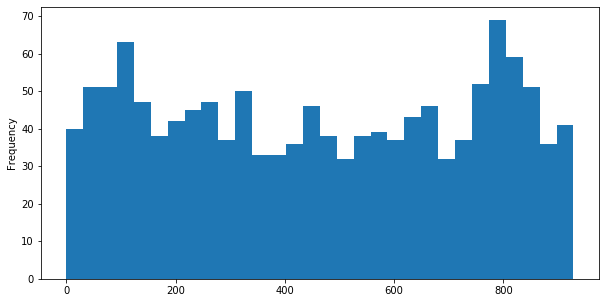

In [76]:
plt.figure(figsize=(10,5))
dataset.ticket_cat.plot.hist(bins=30)


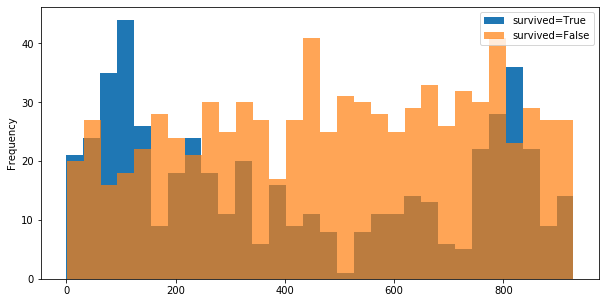

In [77]:
plt.figure(figsize=(10,5))
dataset[dataset.survived==True].ticket_cat.plot.hist(bins=30, label="survived=True")
dataset[dataset.survived==False].ticket_cat.plot.hist(bins=30, label="survived=False", alpha=0.7)
plt.legend()

Question : can you think of another encoding method for ticket ?

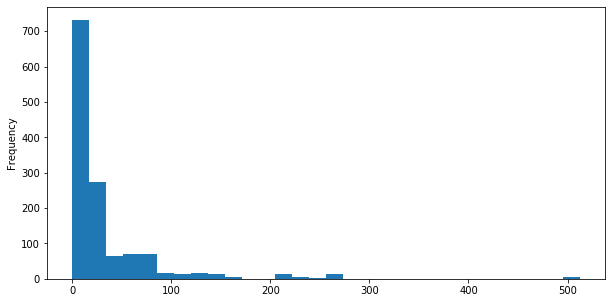

In [82]:
plt.figure(figsize=(10,5))
dataset.fare.plot.hist(bins=30)

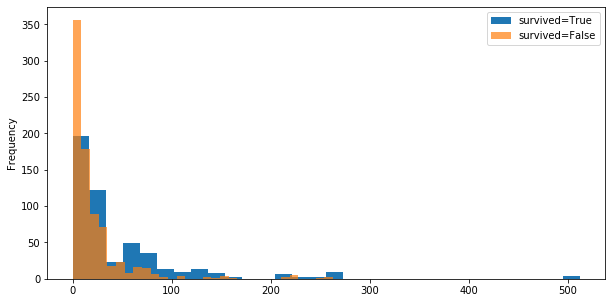

In [496]:
plt.figure(figsize=(10,5))
dataset[dataset.survived == True].fare.plot.hist(label="survived=True", bins=30)
dataset[dataset.survived == False].fare.plot.hist(label="survived=False", bins=30, alpha=0.7)
plt.legend()

##### Leaf impurity

Question : what is the principle after which the tree is built?

For DecisionTreeClassifier we need to find the best splits based on node impurities. A node with impurity 0 means that it contains samples only from one class (ideal scenario). If the impurity is bigger than 0, it means that the node contains samples from both classes. <br>
Algorithm target is to create nodes with impurity as close as possible to 0. 

Common measures of impurity are [gini, entropy and misclasificaion](https://scikit-learn.org/stable/modules/tree.html#classification-criteria). 

<img src="https://raw.githubusercontent.com/tlapusan/tree_based_models_workshop/master/resources/images/node_impurity.png" alt="drawing" width="60%" height="60%"/>

Information gain (IG) is used to select the best split. <br>
The feature which generate the biggest IG is chosen to split the node.

<img src="https://raw.githubusercontent.com/tlapusan/tree_based_models_workshop/master/resources/images/information_gain.png" alt="drawing" width="60%" height="60%"/>

In [497]:
def get_gini(_samples):
    return (_samples[0]/sum(_samples) * (1 - _samples[0]/sum(_samples))) + (_samples[1]/sum(_samples)*(1-_samples[1]/sum(_samples)))


In [498]:
samples = [20, 50]
get_gini(samples)

0.40816326530612246

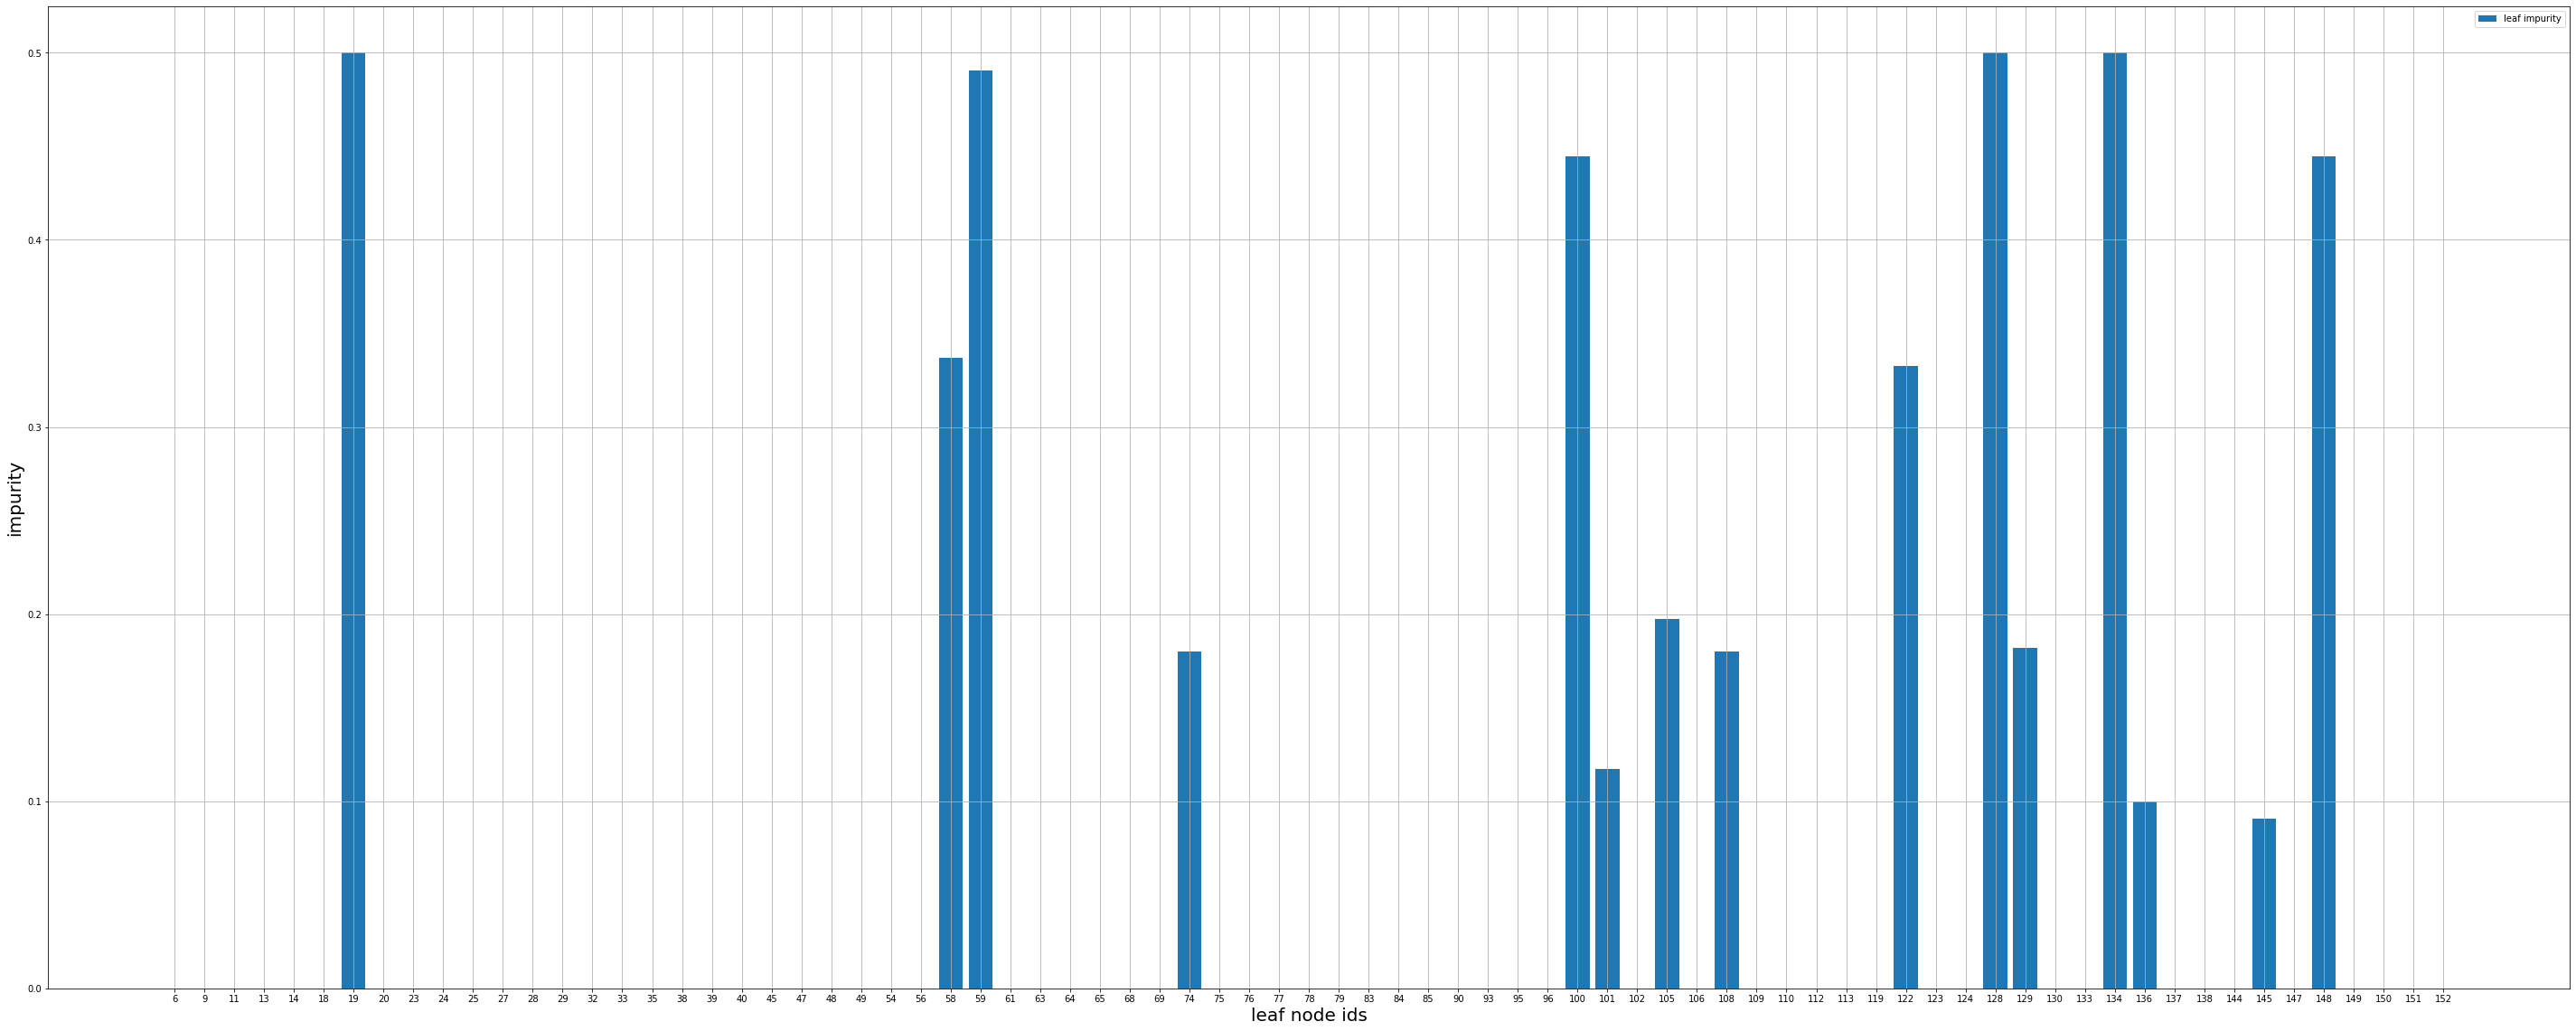

In [84]:
dts.show_leaf_impurity(figsize=(50,20))

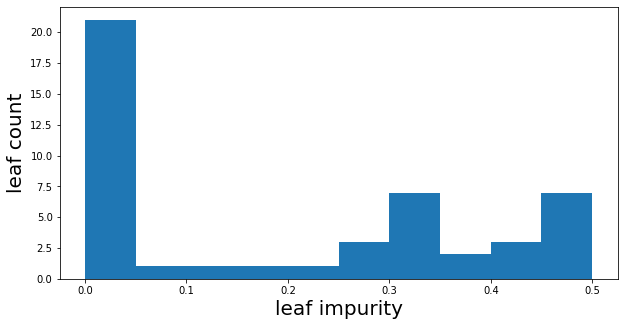

In [500]:
dts.show_leaf_impurity_distribution()

##### Leaf samples

Does the number of samples from leaves matter ?

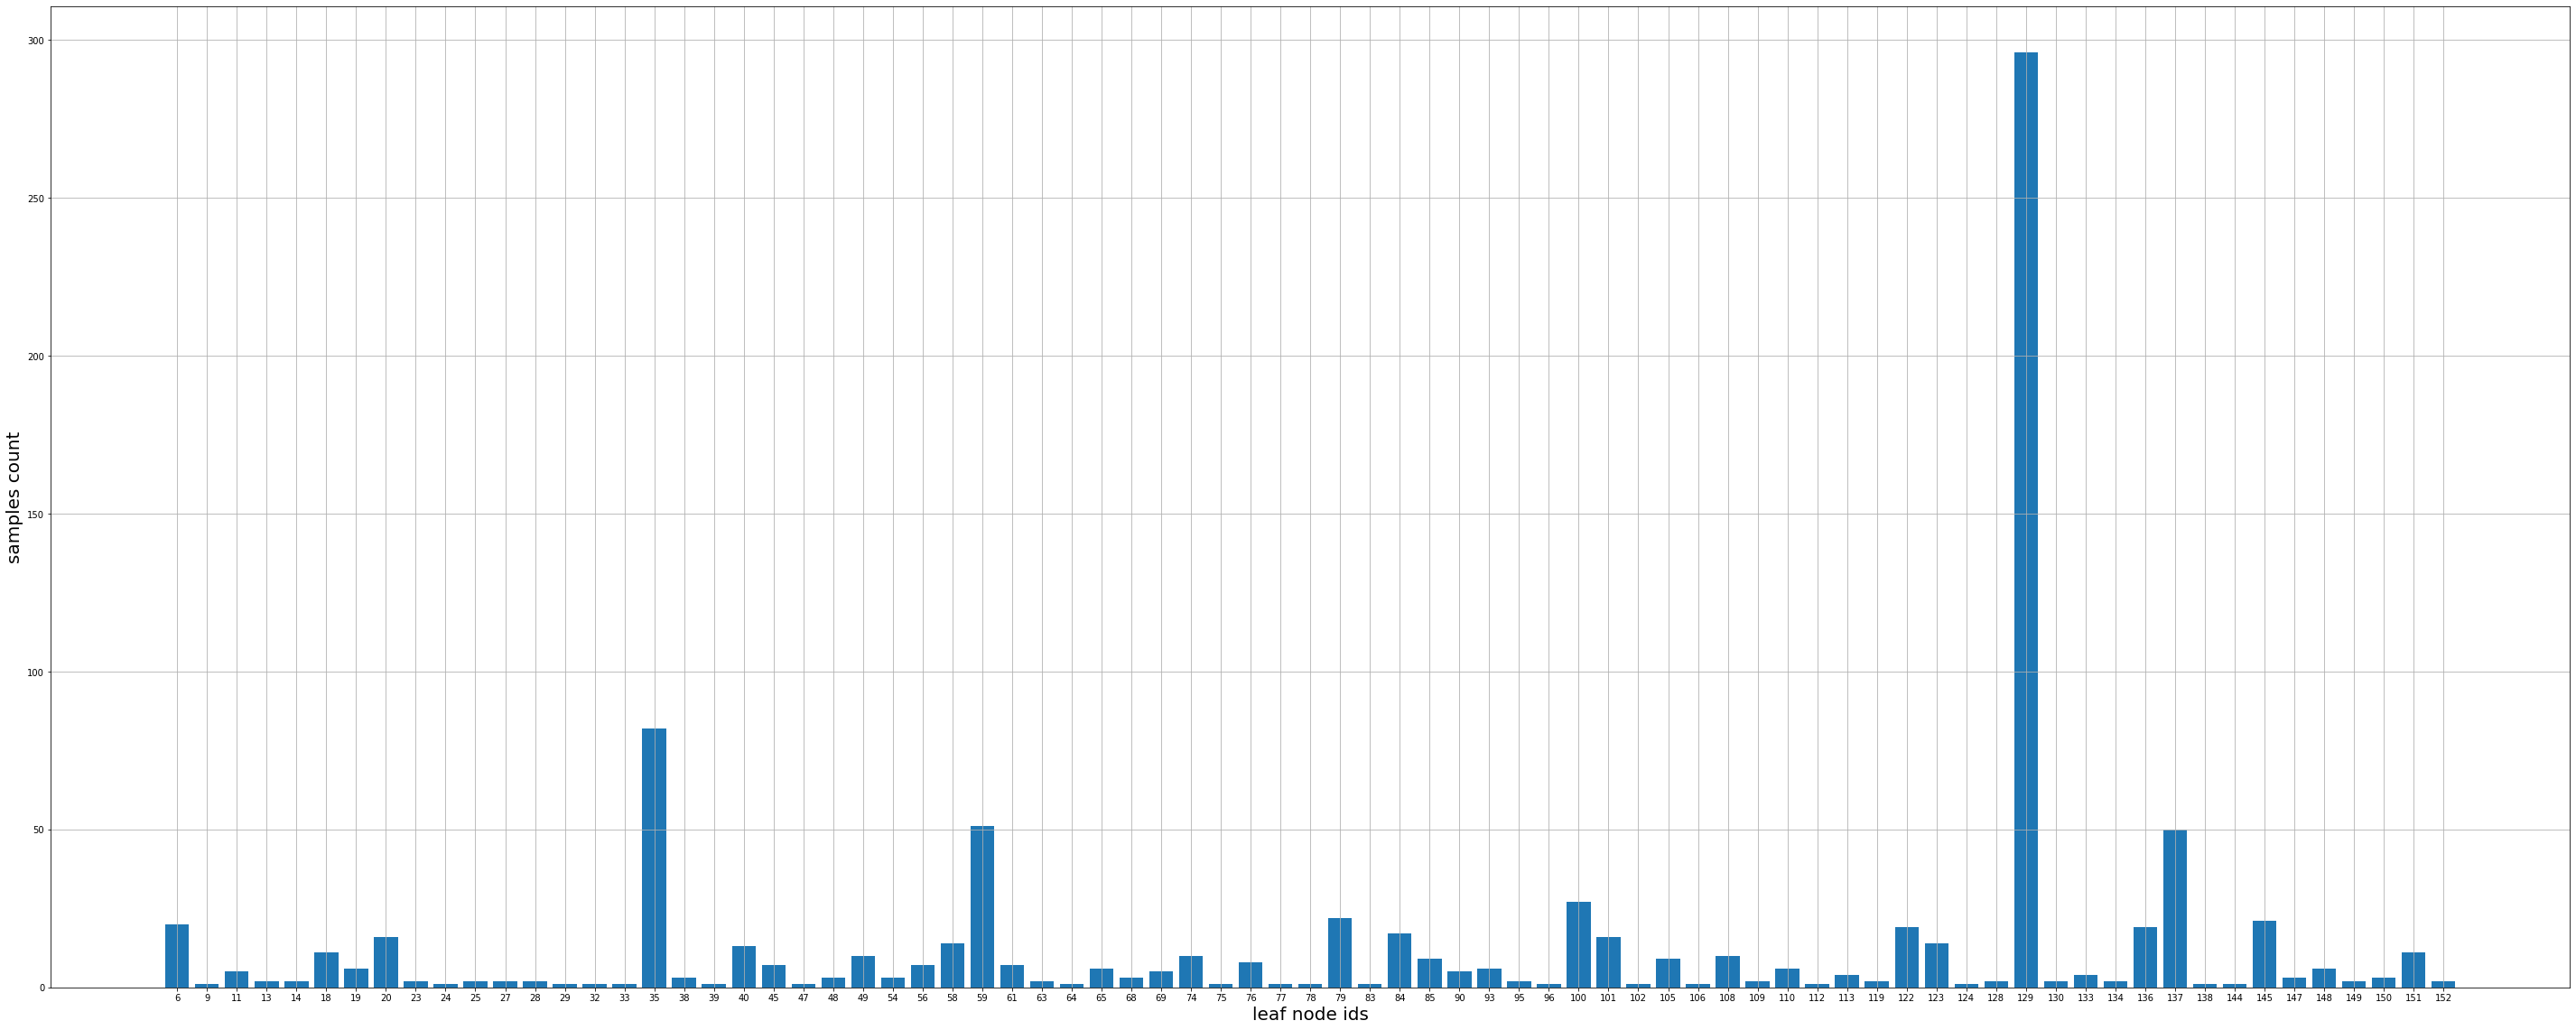

In [85]:
dts.show_leaf_samples(figsize=(50,20))

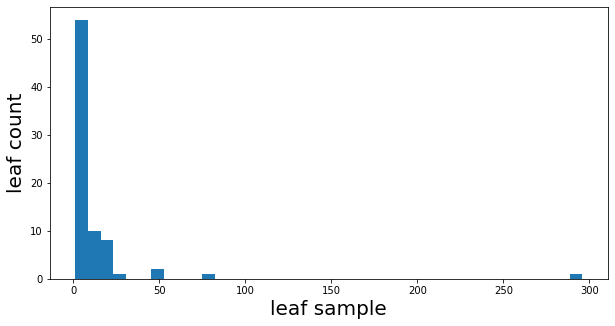

In [87]:
dts.show_leaf_samples_distribution(figsize=(10,5), bins=40)

##### Leaf sample distribution by class 

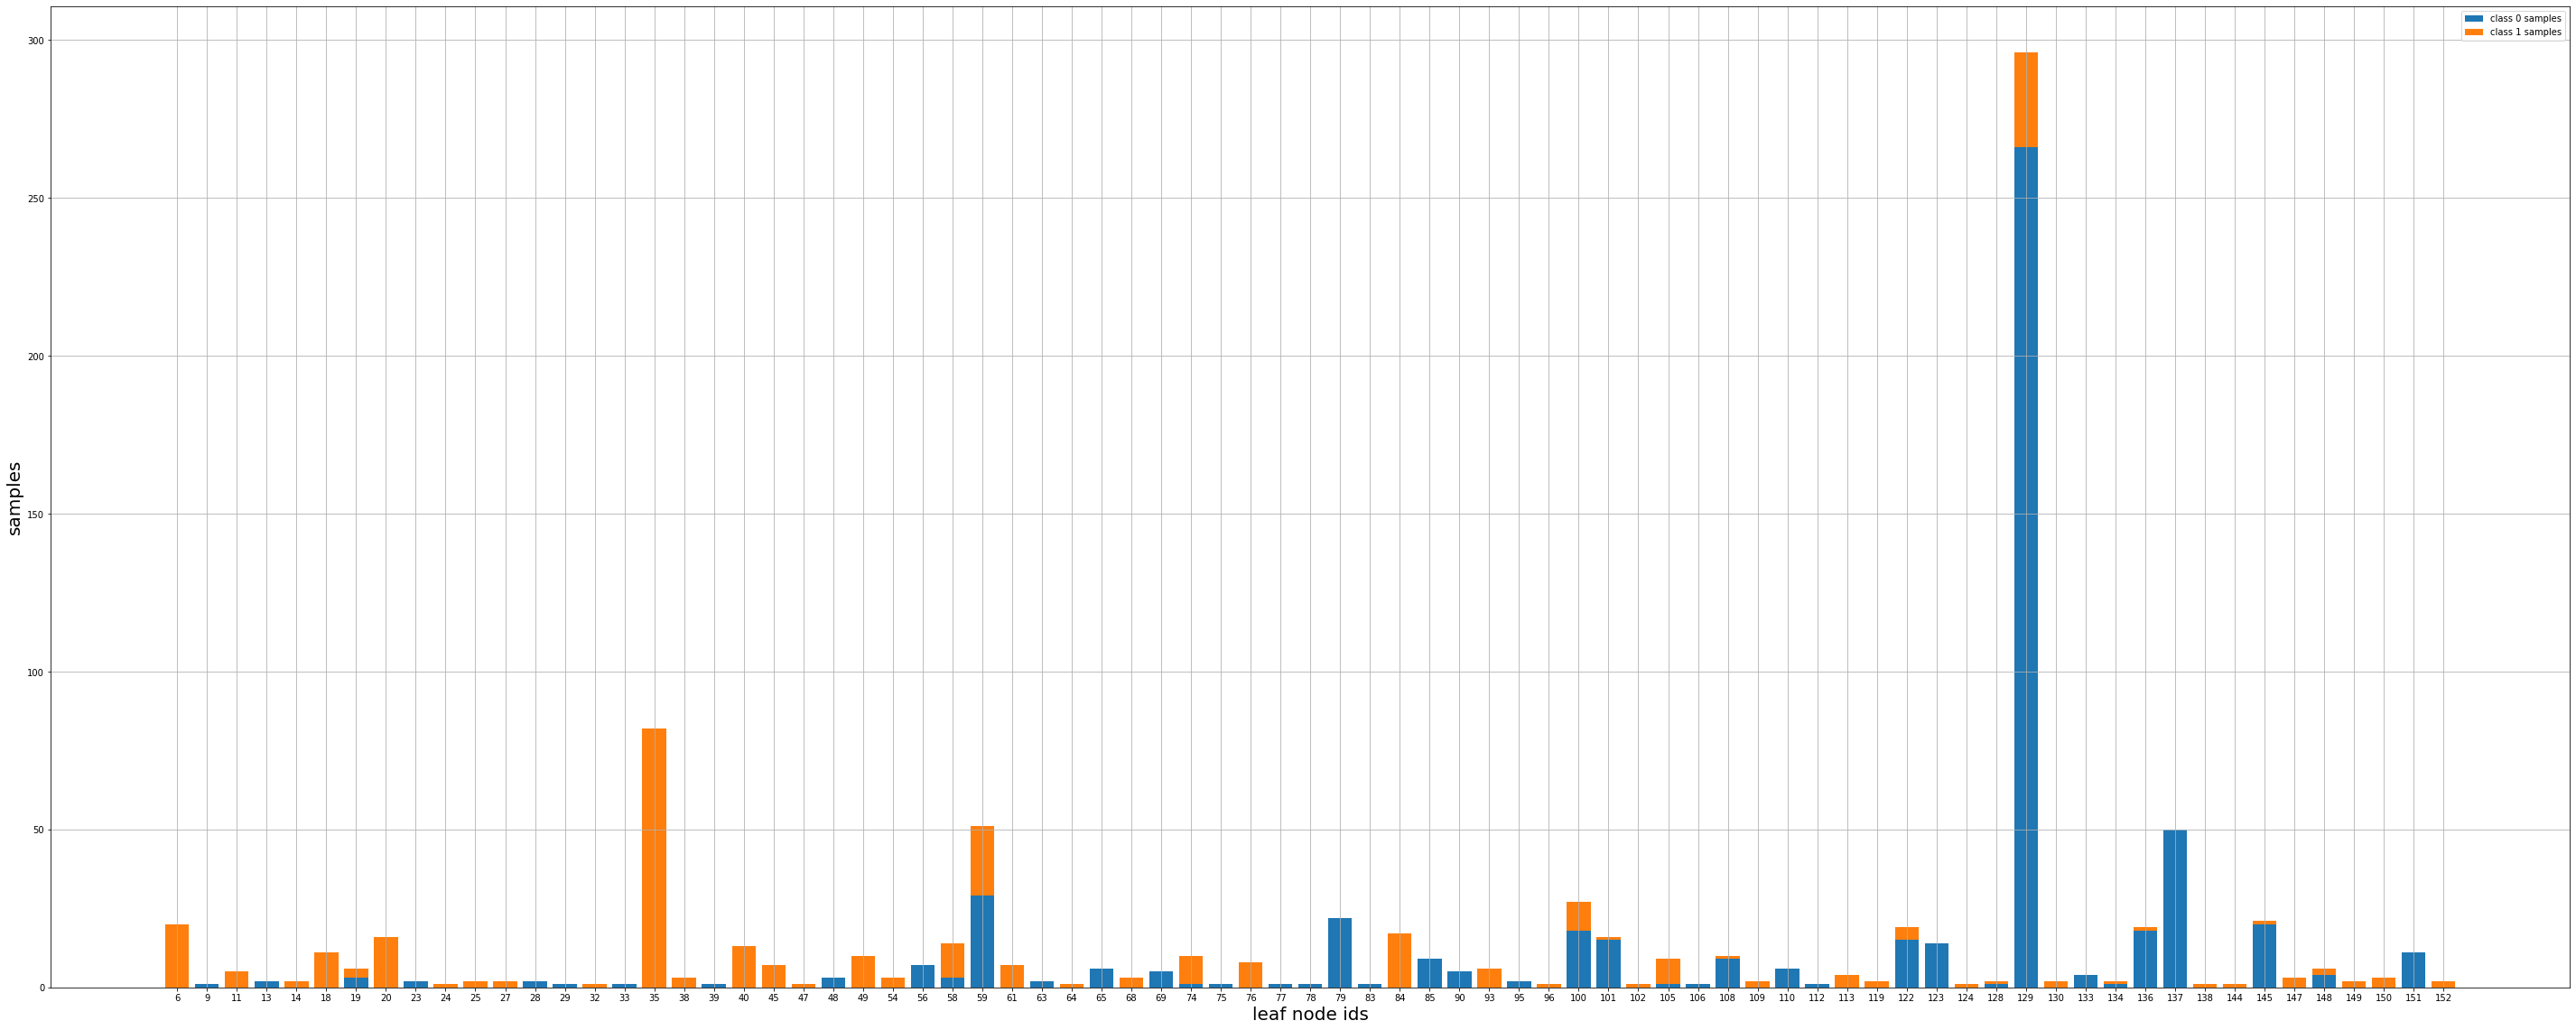

In [88]:
dts.show_leaf_samples_by_class(figsize=(50,20))

In [91]:
dts.get_node_samples(node_id=35).describe()

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

,pclass,gender_cat,age,sibsp,parch,ticket_cat,fare,cabin_cat,embarked_cat
count,82.000000,82.0,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,1.085366,0.0,35.133295,0.500000,0.317073,348.792683,102.719665,75.365854,0.890244
std,0.281145,0.0,13.484956,0.549972,0.468200,356.787094,84.119921,58.918968,1.030475
min,1.000000,0.0,4.000000,0.000000,0.000000,0.000000,31.683300,-1.000000,-1.000000
25%,1.000000,0.0,24.500000,0.000000,0.000000,71.250000,56.157300,16.500000,0.000000
50%,1.000000,0.0,35.000000,0.000000,0.000000,110.500000,79.425000,79.500000,0.000000
75%,1.000000,0.0,44.750000,1.000000,1.000000,804.500000,127.958325,120.000000,2.000000
max,2.000000,0.0,63.000000,2.000000,1.000000,926.000000,512.329200,183.000000,2.000000


In [506]:
dts.get_node_samples(node_id=136).describe()

KeyError: 136

##### Prediction path through the tree

In [96]:
train[features_v3]

,pclass,gender_cat,age,age_missing,sibsp,parch,ticket_cat,fare,fare_missing,cabin_cat,cabin_missing,embarked_cat,embarked_missing
764,3,1,26.000000,False,1,2,750,20.5750,False,-1,True,2,False
561,2,1,59.000000,False,0,0,167,13.5000,False,-1,True,2,False
853,3,1,25.000000,False,0,0,651,7.2500,False,-1,True,2,False
558,2,0,18.000000,False,0,2,224,13.0000,False,-1,True,2,False
1295,3,1,21.000000,False,0,0,890,7.2500,False,-1,True,2,False
1240,3,1,0.416700,False,0,1,233,8.5167,False,-1,True,0,False
685,3,1,21.000000,False,0,0,678,16.1000,False,-1,True,2,False
1288,3,1,18.000000,False,1,0,330,6.4958,False,-1,True,2,False
863,3,1,28.000000,False,0,0,526,7.8958,False,-1,True,2,False
333,2,0,36.000000,False,0,0,312,13.0000,False,117,False,2,False


In [92]:
sample = train[features_v3].iloc[0]
sample

pclass                   3
gender_cat               1
age                     26
age_missing          False
sibsp                    1
parch                    2
ticket_cat             750
fare                20.575
fare_missing         False
cabin_cat               -1
cabin_missing         True
embarked_cat             2
embarked_missing     False
Name: 764, dtype: object

In [98]:
dts.get_leaf_node_count()

77

INFO - Make a prediction for sample pclass                   3
gender_cat               1
age                     26
age_missing          False
sibsp                    1
parch                    2
ticket_cat             750
fare                20.575
fare_missing         False
cabin_cat               -1
cabin_missing         True
embarked_cat             2
embarked_missing     False
Name: 764, dtype: object
INFO - decision path [  0  80  86 114 115 116 117 125 131 135 137]


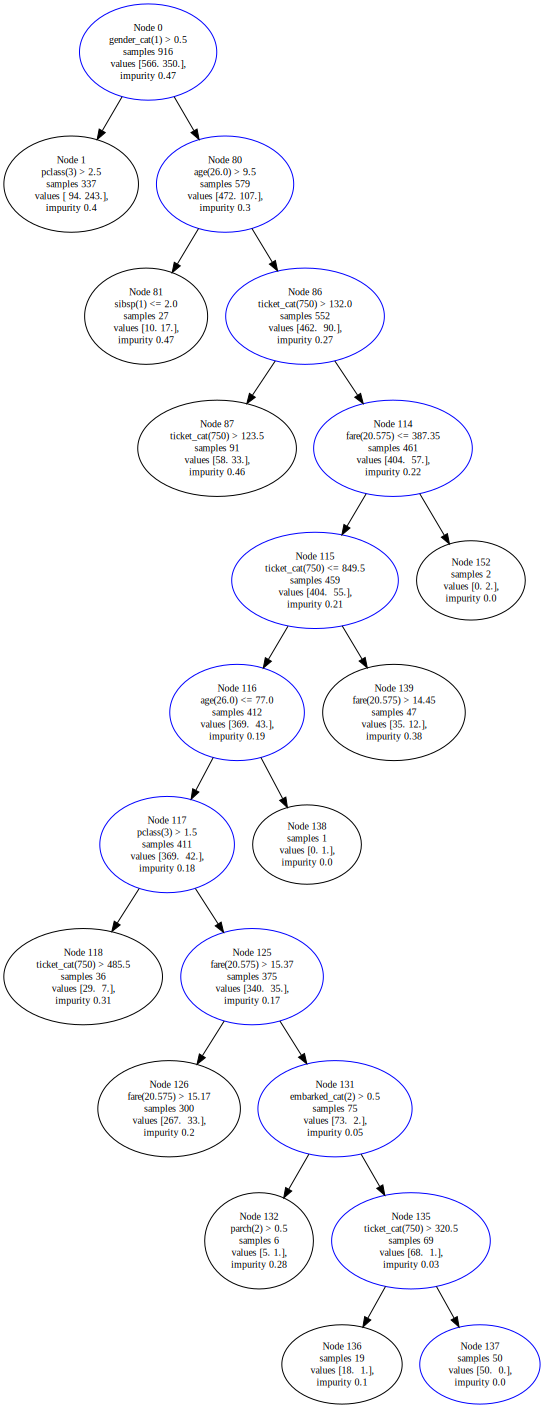

In [97]:
dts.show_decision_tree_prediction_path(sample)

### Underfitting and overfitting

The performance of a ML model can be in three states :
- Underfitting, when the model cannot learn and find patterns into the data, so it perform badly both on training and validation datasets
- Overfitting, when the model learns too well every small details from training dataset, so it's a big chance to have poor performance on validation dataset(it will not generalize)
- Appropriate fitting - the ideal scenario, when the model will have good performance on both training and validation datasets

<img src="https://raw.githubusercontent.com/tlapusan/tree_based_models_workshop/master/resources/images/underfitting_overfitting.png" />

### Hyperparameter tuning
Hyperparameters are those parameters we can set when we initialize a ML model. Their values can have a big impact 
into model performance.

How do we change them ? First we need to <b>understand if our model is overfitting or underfitting</b> and based on this information to change corresponding hyperparameters values. <br>
It is recommended to start changing the hyperparamete values after their importance. For exemple, in a DecisionTree start with max_depth, min_samples_split, min_samples_leaf, etc

Don’t exagerate and spend too much time to tune hyperparameters, especially in the first phase of the project. Would be recommended to spend that time for data understanding, feature engineering.

[DecisionTreeClassifier hyperparamenters](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

#### max_depth

In [ ]:
max_depth_values = [1, 2, 3, 5, 10, 30, 60, 100]
train_accuracy = []
validation_accuracy = []
for depth in max_depth_values:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(train[features_v3], train[target])
    train_accuracy.append(accuracy_score(train[target], dt.predict(train[features_v3])))
    validation_accuracy.append(accuracy_score(validation[target], dt.predict(validation[features_v3])))

In [ ]:
plt.figure(figsize=(10,5))
plt.xticks(range(0, len(max_depth_values)), max_depth_values)
plt.plot(train_accuracy, label="train accuracy")
plt.plot(validation_accuracy, label="validation accuracy")
plt.grid()
plt.legend()

#### min_samples_split
The minimum number of samples required to split an internal node

In [ ]:
train_accuracy = []
validation_accuracy = []
min_samples_split_values = [2, 5, 10, 15, 20, 30, 40, 50, 70, 100]
for min_samples_split in min_samples_split_values:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(train[features_v3], train[target])
    train_accuracy.append(accuracy_score(train[target], dt.predict(train[features_v3])))
    validation_accuracy.append(accuracy_score(validation[target], dt.predict(validation[features_v3])))

In [ ]:
plt.figure(figsize=(10,5))
plt.xticks(range(0, len(min_samples_split_values)), min_samples_split_values)
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.grid()

#### Try multiple hyperparameters  
Trying multiple hyperparameter values in the same time can be done manually or [automatically](https://scikit-learn.org/stable/modules/grid_search.html).

In [431]:
hyperparameters_values = []
train_accuracy = []
validation_accuracy = []
max_depth_values = [1, 2, 3, 5, 10, 30, 60, 100]
min_samples_split_values = [2, 5, 10, 15, 20, 30, 40, 50]
best_max_depth =0
best_min_sample_split = 0
best_accuracy = 0

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        dt.fit(train[features_v3], train[target])

        hyperparameters_values.append(f"{max_depth},{min_samples_split}")
        train_accuracy.append(accuracy_score(train[target], dt.predict(train[features_v3])))

        val_acc = accuracy_score(validation[target], dt.predict(validation[features_v3]))
        validation_accuracy.append(val_acc)
        
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_max_depth = max_depth
            best_min_sample_split = min_samples_split
        

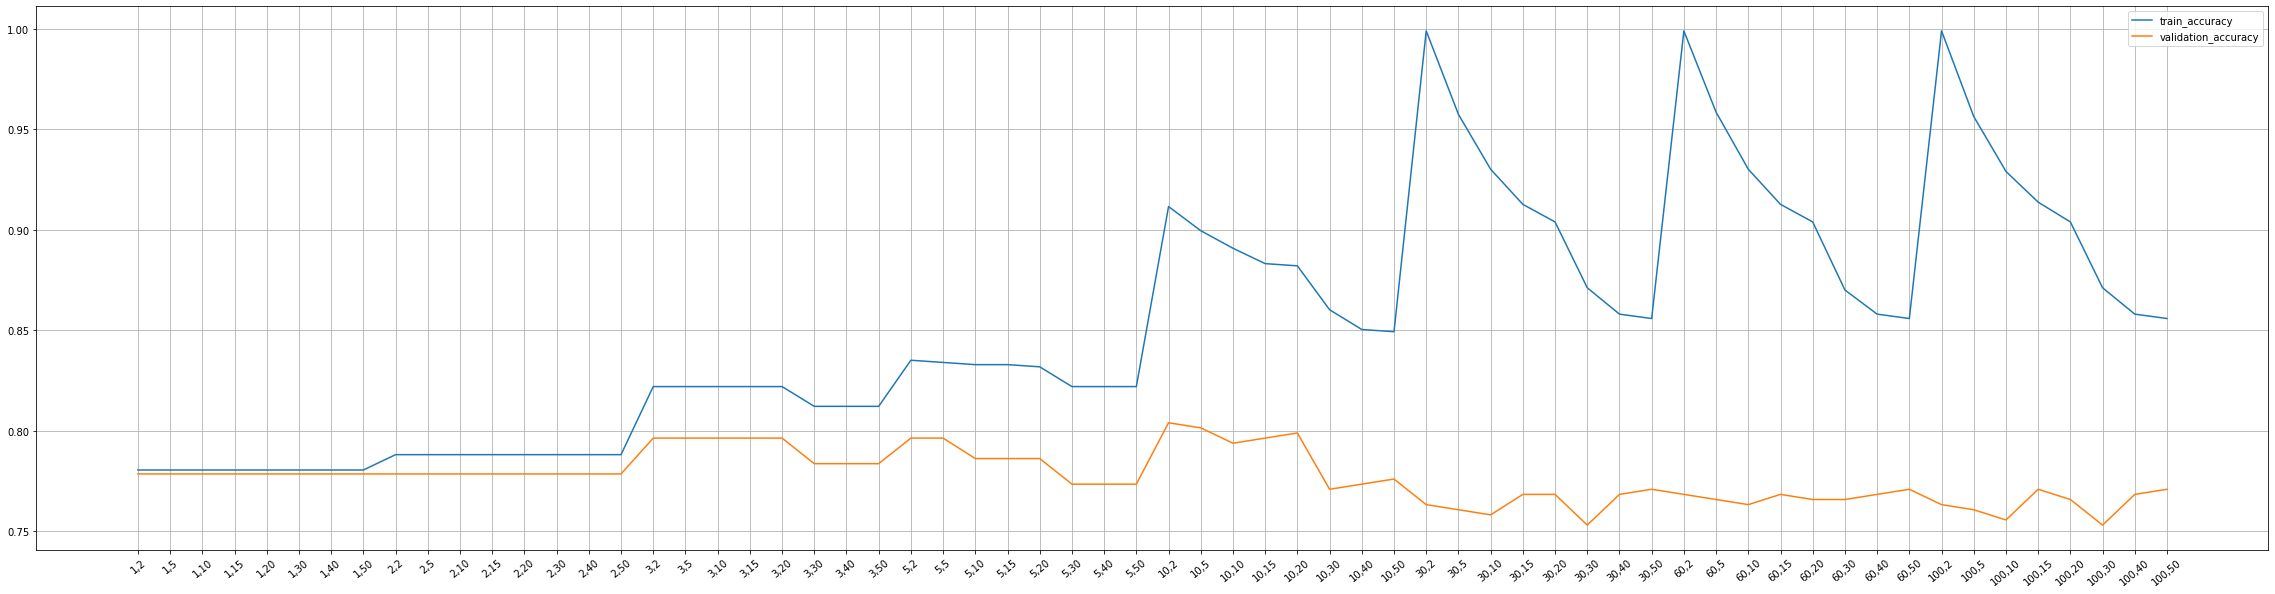

In [432]:
plt.figure(figsize=(40,10))
plt.xticks(range(0, len(hyperparameters_values)), hyperparameters_values, rotation='40')
plt.plot(train_accuracy, label="train_accuracy")
plt.plot(validation_accuracy, label="validation_accuracy")
plt.grid()
plt.legend()

In [433]:
print(f"best_max_depth {best_max_depth}, best_min_sample_split {best_min_sample_split}, best validation accuracy {best_accuracy}" )


best_max_depth 10, best_min_sample_split 2, best validation accuracy 0.8040712468193384


In [434]:
dt_final = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_sample_split, random_state=random_state)
dt_final.fit(dataset[features_v3], dataset[target])


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

### DecisionTree prediction confidence

In [177]:
validation["dt_predicted_class"] = dt.predict(validation[features_v3])
validation["dt_predicted_proba"] = [max(predict) for predict in dt.predict_proba(validation[features_v3])]

In [194]:
print(f"validation size {validation.shape[0]}, correct predictions {validation[validation[target] == validation['dt_predicted_class']].shape[0]}, wrong predictions {validation[validation[target] != validation['dt_predicted_class']].shape[0]}")

validation size 393, correct predictions 303, wrong predictions 90


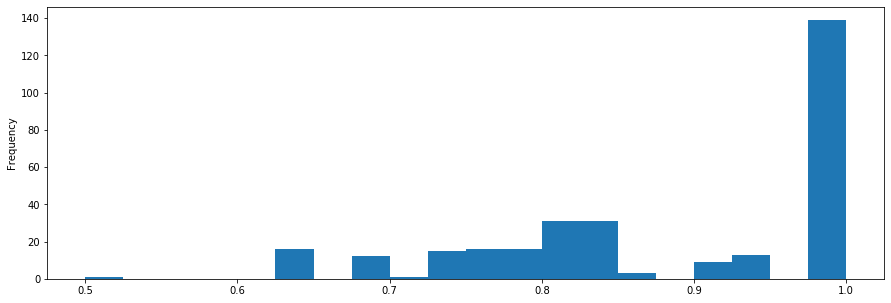

In [215]:
plt.figure(figsize=(15,5))
validation[validation[target] == validation["dt_predicted_class"]].dt_predicted_proba.plot.hist(bins=20)

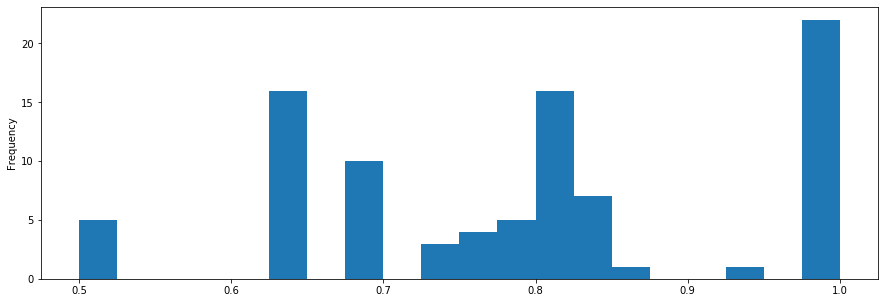

In [216]:
plt.figure(figsize=(15,5))
validation[validation[target] != validation["dt_predicted_class"]].dt_predicted_proba.plot.hist(bins=20)

# Initialize and fit a RandomForest

A Random Forest is a ML model that trains a set of decision trees on various sub-samples of the dataset(bagging) and uses averaging to improve the predictive accuracy and control over-fitting.

<img src="https://raw.githubusercontent.com/tlapusan/tree_based_models_workshop/master/resources/images/random_forest.png"/> <br>


Main characteristics :
- decision trees from RF are independent, so they can be trained in the same time, taking advantage of parallel computing
- each tree is trained with a slightly different input of data
- each tree should have a good performance and also to be uncorrelated between them
- the average predictions is always better than a single model prediction. 

TODO - put bagging visualisation

### Randomness from RandomForest 
Randomness in RF is given by :
- random input for each tree
- random sample of features for each split node (hyperparameter max_features)


In [99]:
train_accuracy = []
validation_accuracy = []
rf_iterations = 10
for i in range(rf_iterations):
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, bootstrap=None, max_features=0.5)
    rf.fit(train[features_v3], train[target])
    
    train_accuracy.append(accuracy_score(train[target], rf.predict(train[features_v3])))
    validation_accuracy.append(accuracy_score(validation[target], rf.predict(validation[features_v3])))
    

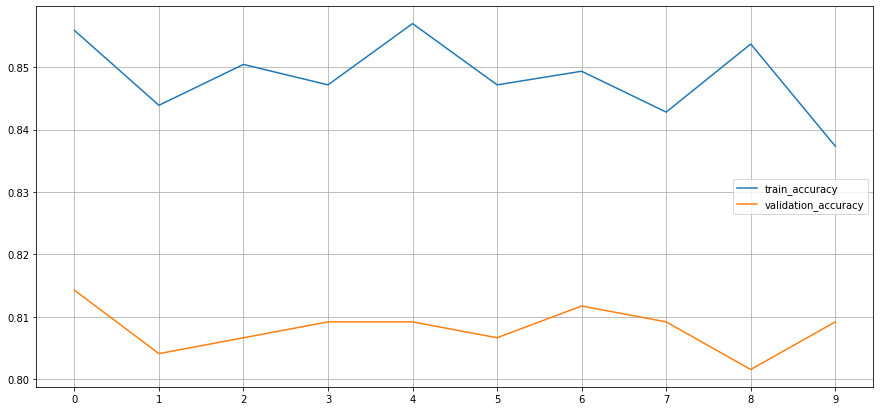

In [441]:
plt.figure(figsize=(15,7))
plt.xticks(range(0, rf_iterations))
plt.plot(train_accuracy, label="train_accuracy")
plt.plot(validation_accuracy, label="validation_accuracy")
plt.grid()
plt.legend()

### kfold validation
Splitting our dataset in two parts is the common and easiest one, but not all the time the most effective, especially for small datasets. We can check if this is happening if we make multiple holdout splits and we receive different accuracies for validation datasets. <br>

As you can observe, we can play a lot with hyperparameter tuning until we get the best result. The main risk is that we could changed those hyperparameters until our model performs optimally only on the validation set and will not perform optimally/generalize in production environment.

To tackle this, we can apply another validation strategy, named k-fold. <br>
The dataset set is split into k smaller sets. The following procedure is followed for each of the k “folds”:
- a model is trained using k-1 of the folds as training data
- the resulting model is validated on the remaining part of  the data, 1 fold

<img src="https://raw.githubusercontent.com/tlapusan/tree_based_models_workshop/master/resources/images/kfold.png" />




In [237]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=random_state)

In [238]:
k = 5
kfold =  StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

In [239]:
kfold_stats = cross_validate(rf, dataset[features_v3], dataset[target], cv=kfold, scoring="accuracy", return_train_score=True  )


In [240]:
kfold_stats

{'fit_time': array([0.125036  , 0.11418295, 0.09346199, 0.0936141 , 0.10118198]),
 'score_time': array([0.01151299, 0.00904608, 0.00884771, 0.00895691, 0.01089191]),
 'test_score': array([0.80916031, 0.80534351, 0.7480916 , 0.79389313, 0.83141762]),
 'train_score': array([0.84622732, 0.84813754, 0.84622732, 0.84718243, 0.82919847])}

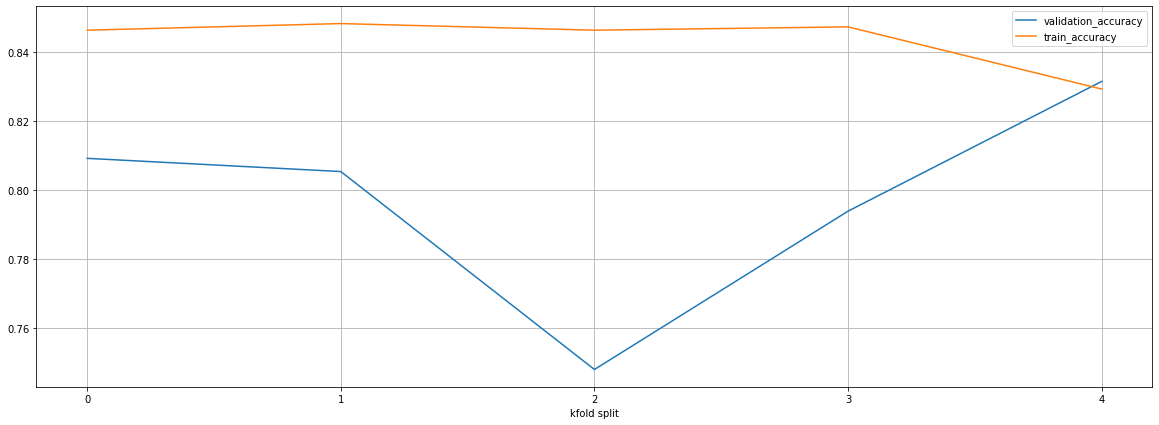

In [241]:
_ = plt.figure(figsize=(20,7))
_ = plt.xticks(range(0, k))
_ = plt.xlabel("kfold split")
_ = plt.plot(kfold_stats["test_score"], label="validation_accuracy")
_ = plt.plot(kfold_stats["train_score"], label="train_accuracy")
_ = plt.legend()
_ = plt.grid()


In [242]:
kfold_stats["train_score"].mean()

0.8433946134721524

In [243]:
kfold_stats["test_score"].mean()

0.7975812348278787

#### OOB score (Out Of Bag)
For each tree, we take randomely only 62.3% from the training set. This means that the rest of 37.7% is not used at all (by default). <br>
By setting the hyperparameter oob_score=True, we use out-of-bag samples to estimate the model accuracy. 

Question : 
- which is the main advantage of using oob_score ?
- In which situation the oob_score is not relevant ?

In [244]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, oob_score=True, random_state=random_state)
rf.fit(dataset[features_v3], dataset[target])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=1234,
                       verbose=0, warm_start=False)

In [245]:
rf.oob_score_

0.7929717341482048

### Model interpretation

In [100]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=random_state)
rf.fit(train[features_v3], train[target])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [101]:
rf.feature_importances_

array([7.94213203e-02, 4.38256951e-01, 8.86478488e-02, 6.15976211e-03,
       3.86184535e-02, 3.57337242e-02, 9.40343662e-02, 9.09800425e-02,
       0.00000000e+00, 6.95524379e-02, 3.67126926e-02, 2.18017873e-02,
       8.06135609e-05])

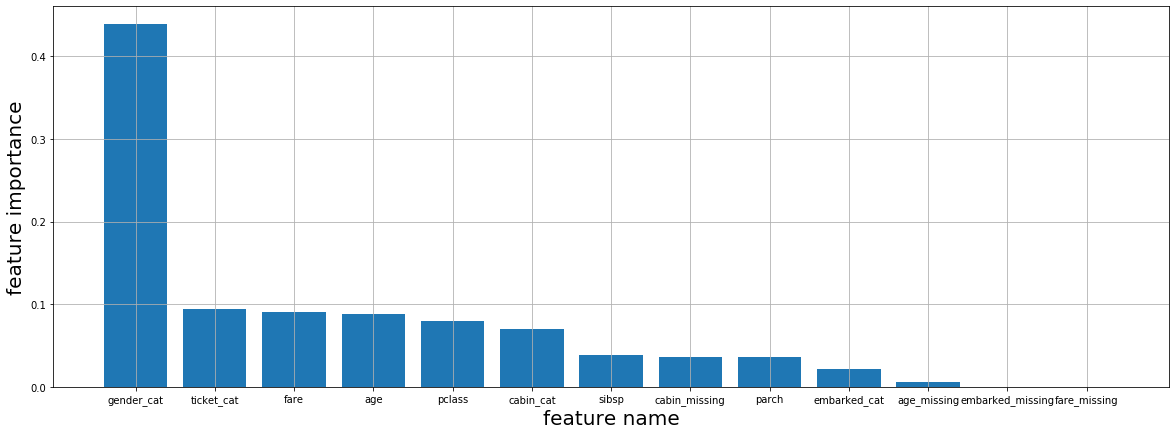

In [102]:
feature_names, feature_importances = zip(
            *sorted(list(zip(rf.feature_importances_, features_v3)), key=lambda tup: tup[0],
                    reverse=True))
plt.figure(figsize=(20,7))
plt.bar(feature_importances, feature_names)
plt.xlabel("feature name", fontsize=20)
plt.ylabel("feature importance", fontsize=20)
plt.grid()
plt.show()

In [447]:
rf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=822569775, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=2137449171, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min

In [264]:
dts = DecisionTreeStructureClassifier(rf.estimators_[10], train, features_v3, target)

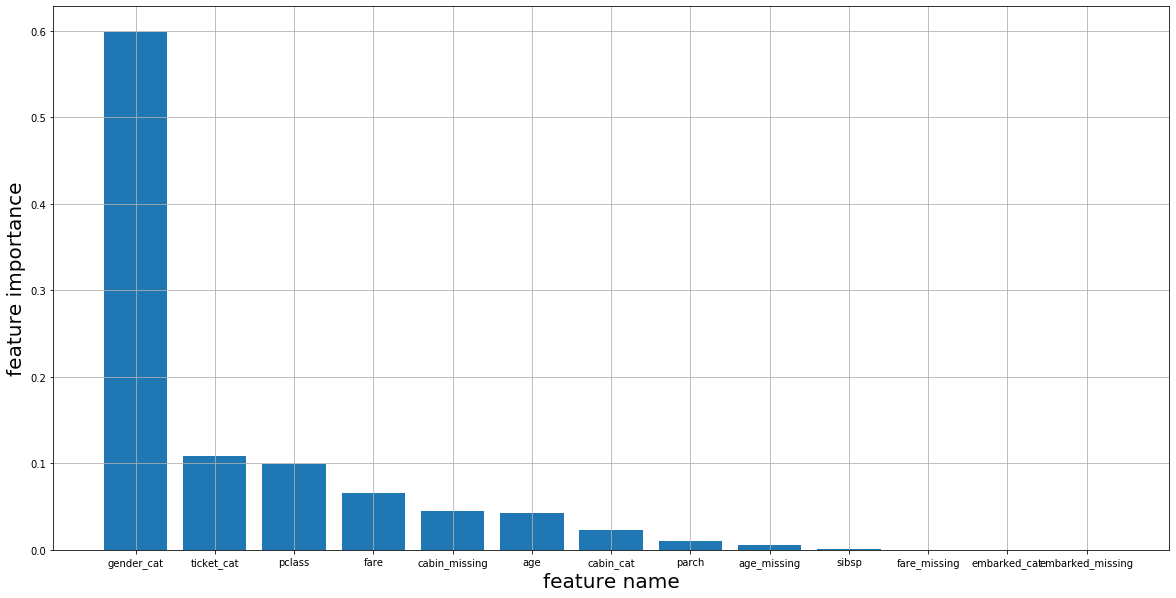

In [265]:
dts.show_features_importance()

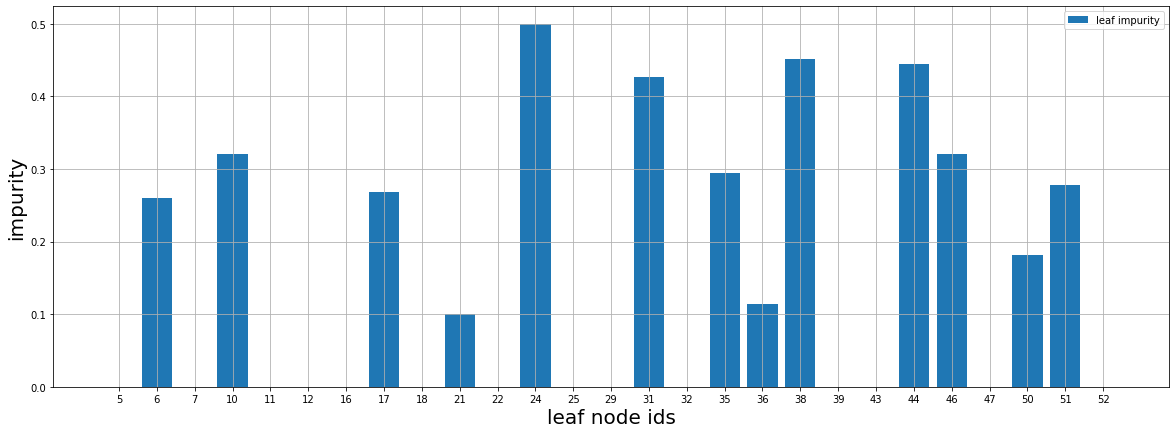

In [268]:
dts.show_leaf_impurity(figsize=(20, 7))

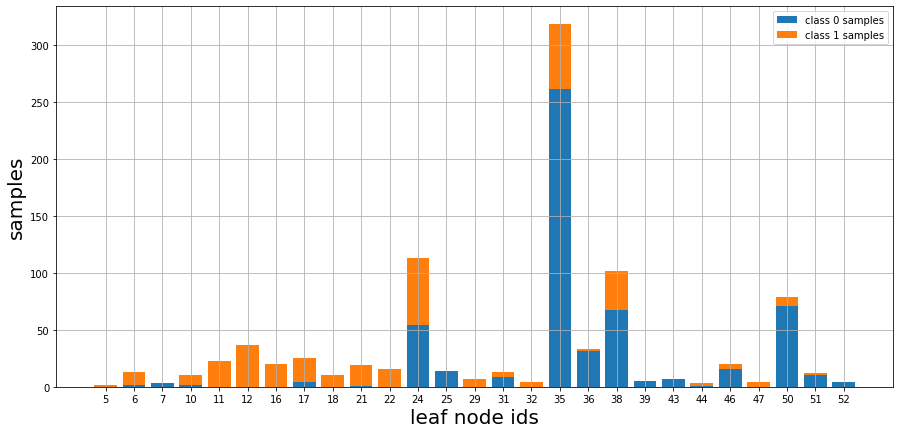

In [271]:
dts.show_leaf_samples_by_class(figsize=(15,7))

### RF prediction confidence

In [448]:
validation["rf_predicted_class"] = rf.predict(validation[features_v3])
validation["rf_predicted_proba"] = [max(predict_proba) for predict_proba in rf.predict_proba(validation[features_v3])]

In [449]:
validation[[target, "rf_predicted_class", "rf_predicted_proba"]].head(5)

,survived,rf_predicted_class,rf_predicted_proba
403,False,False,0.838171
889,True,False,0.855092
238,True,True,0.860659
349,True,True,0.817391
643,True,False,0.838627


In [450]:
print(f"Number of validation samples {validation.shape[0]}")
print(f"Number of correct prediction from validation {validation[validation[target] == validation['rf_predicted_class']].shape[0]}")
print(f"Number of incorrect prediction from validation {validation[validation[target] != validation['rf_predicted_class']].shape[0]}")
  

Number of validation samples 393
Number of correct prediction from validation 320
Number of incorrect prediction from validation 73


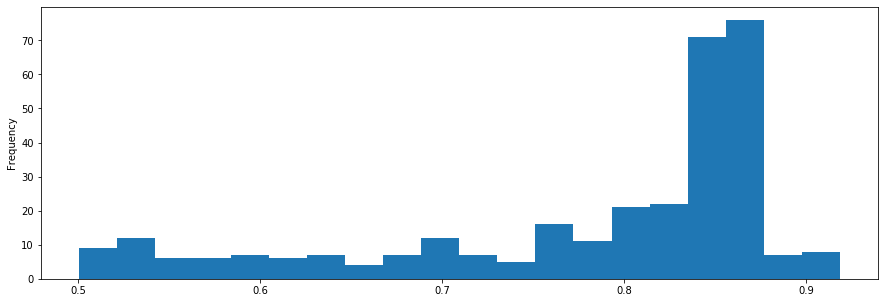

In [452]:
plt.figure(figsize=(15,5))
validation[validation[target] == validation["rf_predicted_class"]].rf_predicted_proba.plot.hist(bins=20)

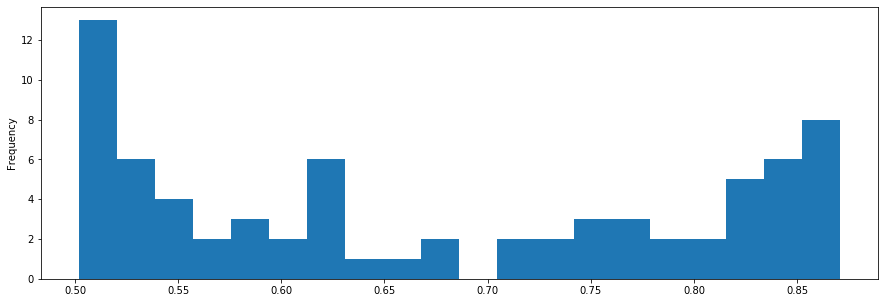

In [454]:
plt.figure(figsize=(15,5))
validation[validation[target] != validation["rf_predicted_class"]].rf_predicted_proba.plot.hist(bins=20)

### Prediction confidence

In [456]:
sample = validation[features_v3].iloc[20]
sample

pclass                  2
gender_cat              1
age                    26
age_missing         False
sibsp                   1
parch                   1
ticket_cat            211
fare                   29
fare_missing        False
cabin_cat              -1
cabin_missing        True
embarked_cat            2
embarked_missing    False
Name: 360, dtype: object

In [457]:
[rf_dt.predict_proba([sample])[0] for rf_dt in rf.estimators_]

[array([0.85130112, 0.14869888]),
 array([0.91304348, 0.08695652]),
 array([0.97727273, 0.02272727]),
 array([0.28571429, 0.71428571]),
 array([0.23333333, 0.76666667]),
 array([0.8852459, 0.1147541]),
 array([0.57142857, 0.42857143]),
 array([0.90062112, 0.09937888]),
 array([0.87893462, 0.12106538]),
 array([0.84011628, 0.15988372]),
 array([0.93939394, 0.06060606]),
 array([0.83146067, 0.16853933]),
 array([0.98529412, 0.01470588]),
 array([0.97014925, 0.02985075]),
 array([0.1, 0.9]),
 array([0.84246575, 0.15753425]),
 array([0.88073394, 0.11926606]),
 array([0.87878788, 0.12121212]),
 array([0.87254902, 0.12745098]),
 array([0.58333333, 0.41666667]),
 array([0.36464088, 0.63535912]),
 array([0.54545455, 0.45454545]),
 array([0.87468672, 0.12531328]),
 array([0.84756098, 0.15243902]),
 array([0.10144928, 0.89855072]),
 array([0.86649215, 0.13350785]),
 array([0.66169154, 0.33830846]),
 array([0.8952381, 0.1047619]),
 array([0.88647343, 0.11352657]),
 array([0.83571429, 0.16428571])

In [458]:
import statistics

def rf_prediction(rf, sample):
    predict_proba = [rf_dt.predict_proba(sample)[0] for rf_dt in rf.estimators_]
    predict_class = rf.predict(sample)[0]
    predicted_index = 1 if bool(predict_class) else 0

    return (statistics.mean([proba[predicted_index] for proba in predict_proba]), statistics.stdev([proba[predicted_index] for proba in predict_proba]))  




In [459]:
rf_prediction(rf, [sample])

(0.7303440754773618, 0.2486034808761012)

In [461]:
rf.predict_proba([sample])

array([[0.73034408, 0.26965592]])

### std histogram

In [462]:
prediction_std = []
for sample in validation[features_v3].iterrows():
    prediction_std.append(rf_prediction(rf, [sample[1]])[1])

(array([53., 45., 15., 19., 13.,  9., 16., 29., 27., 27., 20., 44., 27.,
        10., 19.,  3.,  4.,  4.,  7.,  2.]),
 array([0.04776846, 0.0642423 , 0.08071614, 0.09718998, 0.11366383,
        0.13013767, 0.14661151, 0.16308535, 0.1795592 , 0.19603304,
        0.21250688, 0.22898072, 0.24545457, 0.26192841, 0.27840225,
        0.29487609, 0.31134994, 0.32782378, 0.34429762, 0.36077146,
        0.37724531]),
 <a list of 20 Patch objects>)

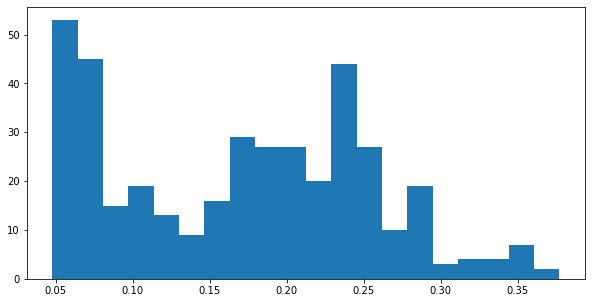

In [463]:
plt.figure(figsize=(10,5))
plt.hist(prediction_std, bins=20)

# Regression algorithms - DecisionTree and RandomForest

Regression algorithms are used when we need to predict a continuous value ! <br>

We will use the same dataset, but now we will try to predict the age of the passanger.

<img src="https://raw.githubusercontent.com/tlapusan/tree_based_models_workshop/master/resources/images/regression_models.jpg" />

In [343]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

from woodpecker.decision_tree_structure_regressor import DecisionTreeStructureRegressor

In [327]:
dataset_reg = dataset.copy()

## Decision Tree Regressor

For DecisionTreeClassifier we needed to find the best splits based on node impurities. The algorithm target is to create nodes with impurity as close as possible to 0. This will result in nodes containing samples almost from one single class.

DecisionTreeRegression needs to predict continuous values, so we will have an 'infinity' set of possible values. Because of this, we cannot rely on node impurity. <br>
Regression criteria used to find the best split is [MSE and MAE](https://scikit-learn.org/stable/modules/tree.html#regression-criteria). Both criterias measure how spread is the data into the node. Algorithm target is to create nodes with a spread as low as possible.

TODO : MAE vs MSE 

<img src="https://raw.githubusercontent.com/tlapusan/tree_based_models_workshop/master/resources/images/decision_tree_regressor_sample.png"/>




In [332]:
features_reg = ['pclass',
 'gender_cat',
 'survived',
 'sibsp',
 'parch',
 'ticket_cat',
 'fare',
 'fare_missing',
 'cabin_cat',
 'cabin_missing',
 'embarked_cat',
 'embarked_missing']
target_reg = "age"

### train/validation split

In [334]:
train_reg, validation_reg = train_test_split(dataset_reg, train_size=0.7, random_state=random_state)

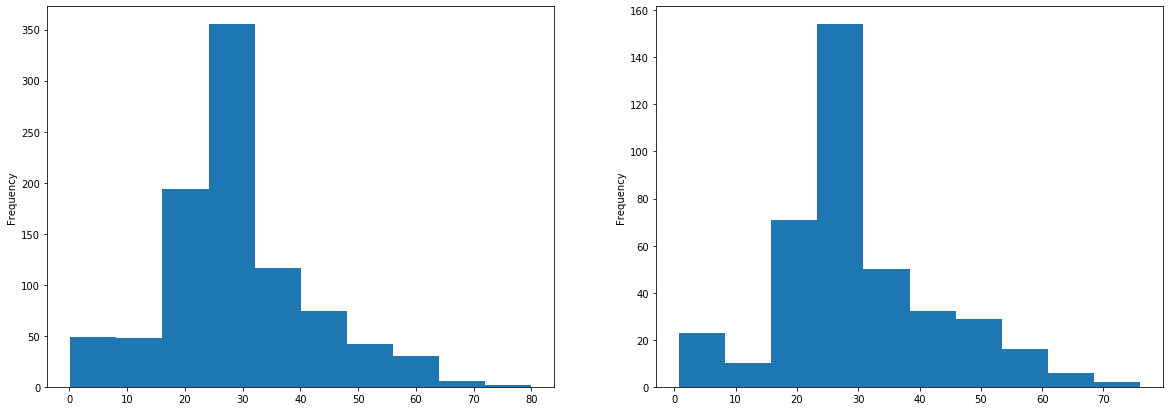

In [465]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
train_reg.age.plot.hist()
plt.subplot(1,2,2)
validation_reg.age.plot.hist()

### Init and fit the model

In [467]:
dt_reg = DecisionTreeRegressor(criterion="mae", max_depth=5, min_samples_split=3, min_samples_leaf=2)
dt_reg.fit(train_reg[features_reg], train_reg[target_reg])

DecisionTreeRegressor(criterion='mae', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

### Prediction description

In [470]:
list(zip(validation_reg[target_reg][:10], dt_reg.predict(validation_reg[features_reg][:10])))

[(29.8811345124283, 29.8811345124283),
 (36.0, 36.0),
 (34.0, 29.8811345124283),
 (54.0, 29.8811345124283),
 (25.0, 29.8811345124283),
 (23.0, 36.0),
 (29.0, 29.8811345124283),
 (1.0, 29.8811345124283),
 (26.5, 29.8811345124283),
 (29.8811345124283, 29.8811345124283)]

### Model validation
<img src="https://raw.githubusercontent.com/tlapusan/tree_based_models_workshop/master/resources/images/MAE_formula.png"/>

In [472]:
print_score_reg(dt_reg, train_reg, validation_reg)

train MAE 7.548126361184634
validation MAE 8.467542338193725


### Model interpretation

In [524]:
dtsr = DecisionTreeStructureRegressor(dt_reg, dataset_reg, features_reg, target_reg)

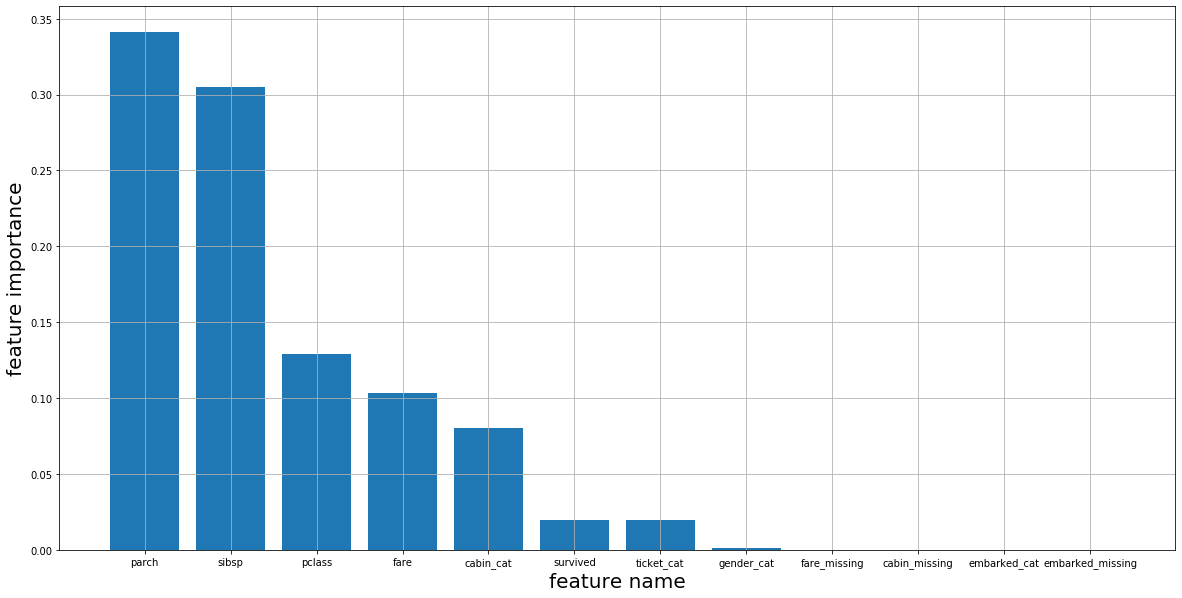

In [525]:
dtsr.show_features_importance()

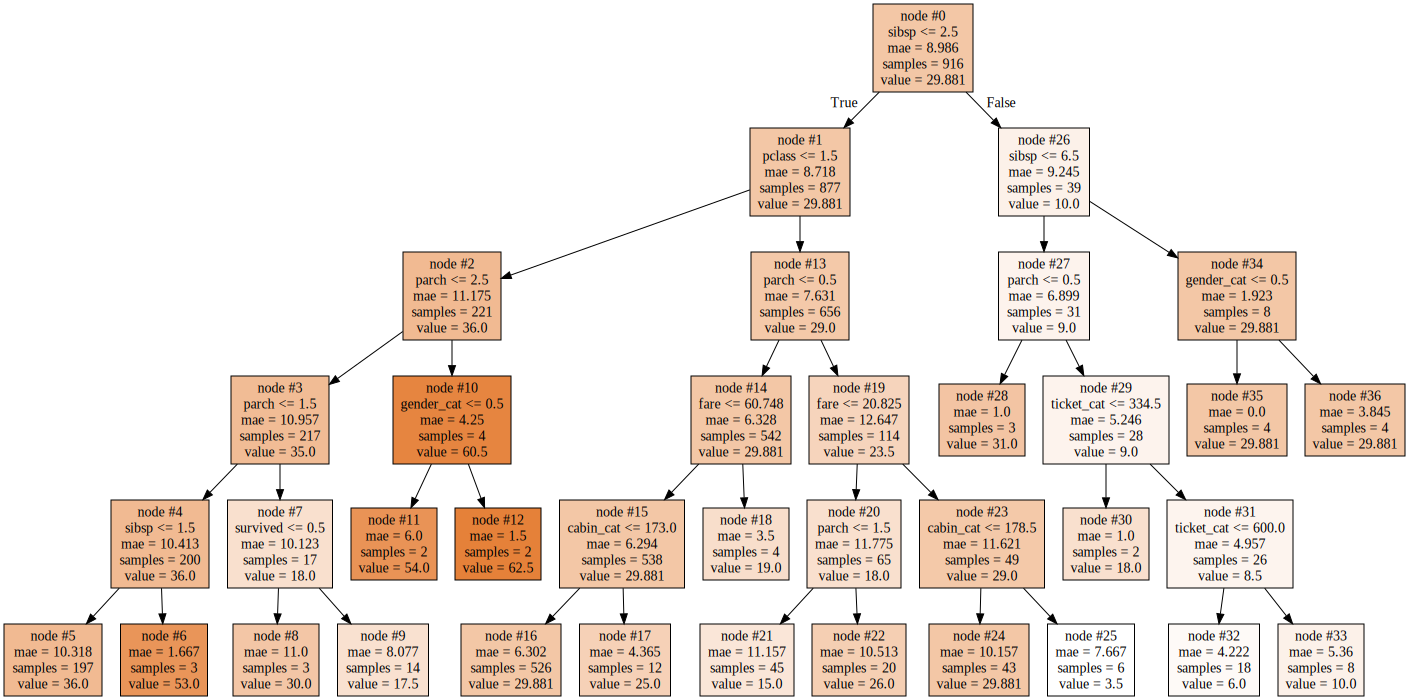

In [526]:
dtsr.show_decision_tree_structure(rotate=False)

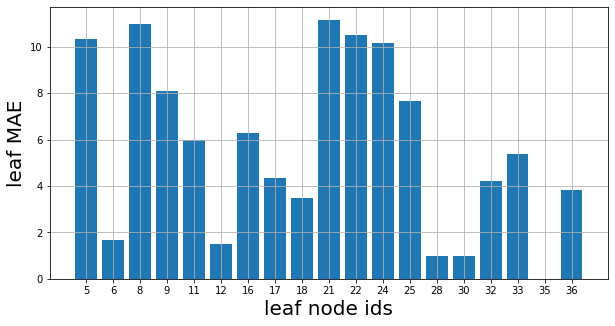

In [527]:
dtsr.show_leaf_regression_criteria()

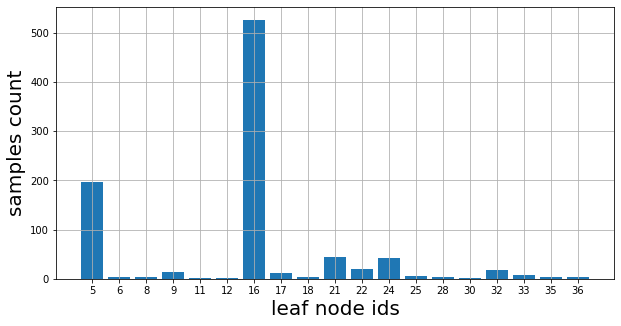

In [528]:
dtsr.show_leaf_samples()

In [533]:
dtsr.get_node_samples(node_id=21).describe()

,pclass,gender_cat,sibsp,parch,ticket_cat,fare,cabin_cat,embarked_cat,age
count,60.000000,60.000000,60.000000,60.0,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2.883333,0.500000,0.783333,1.0,480.933333,14.370347,16.366667,1.333333,16.069057
std,0.323732,0.504219,0.555151,0.0,212.566948,3.943513,52.787700,0.932768,13.713606
min,2.000000,0.000000,0.000000,1.0,217.000000,3.170800,-1.000000,0.000000,0.416700
25%,3.000000,0.000000,0.000000,1.0,269.750000,12.261450,-1.000000,0.000000,3.000000
50%,3.000000,0.500000,1.000000,1.0,467.000000,14.500000,-1.000000,2.000000,15.500000
75%,3.000000,1.000000,1.000000,1.0,666.000000,16.250000,-1.000000,2.000000,28.250000
max,3.000000,1.000000,2.000000,1.0,883.000000,20.525000,184.000000,2.000000,45.000000


In [481]:
sample_reg = validation_reg[features_reg].iloc[0]
sample_reg

pclass                  3
gender_cat              1
survived            False
sibsp                   0
parch                   0
ticket_cat            889
fare                 8.05
fare_missing        False
cabin_cat              -1
cabin_missing        True
embarked_cat            2
embarked_missing    False
Name: 1284, dtype: object

INFO - Make a prediction for sample pclass                  3
gender_cat              1
survived            False
sibsp                   0
parch                   0
ticket_cat            889
fare                 8.05
fare_missing        False
cabin_cat              -1
cabin_missing        True
embarked_cat            2
embarked_missing    False
Name: 1284, dtype: object
INFO - decision path [ 0  1 13 14 15 16]


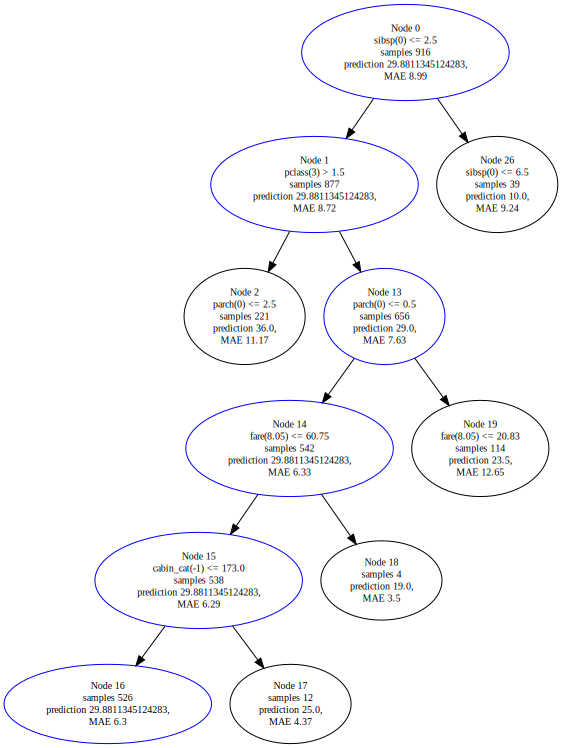

In [482]:
dtsr.show_decision_tree_prediction_path(sample_reg)